## Import Library and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
import warnings
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import f1_score, log_loss, multilabel_confusion_matrix, plot_confusion_matrix
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../input/machine-hack-fake-news-content-detection/Train.csv")

In [3]:
df.head()

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"


## Distribution of the Labels

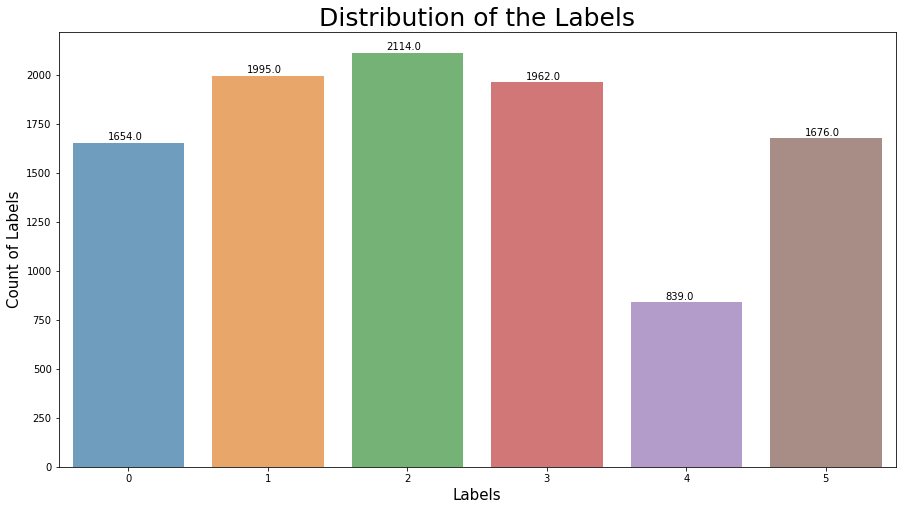

In [40]:
plt.figure(figsize = (15,8))
graph = sns.countplot(data = df, x="Labels", alpha=0.7)
for p in graph.patches:
    graph.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+15))
plt.title("Distribution of the Labels",fontsize=25)
plt.ylabel('Count of Labels', fontsize=15)
plt.xlabel('Labels', fontsize=15)
plt.show()

## Text Preprocessing

**Remove Stopwords and word with length greater than 2**

In [5]:
df['Text'] = df['Text'].str.lower()
stop_words = set(stopwords.words('english'))

df['new_text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words) and len(word) > 2]))
print('With Stopwords: ')
print(df['Text'][1])
print('\n')
print('Without Stopwords: ')
print(df['new_text'][1])

With Stopwords: 
when did the decline of coal start? it started when natural gas took off that started to begin in (president george w.) bushs administration.


Without Stopwords: 
decline coal start? started natural gas took started begin (president george w.) bushs administration.


**Remove Punctuation**

In [6]:
punctuations = list(string.punctuation)

df['clean_text'] = df['new_text'].str.replace('[^\w\s]','')
print('With Punctuation: ')
print(df['new_text'][1])
print('\n')
print('Without Punctuation: ')
print(df['clean_text'][1])

With Punctuation: 
decline coal start? started natural gas took started begin (president george w.) bushs administration.


Without Punctuation: 
decline coal start started natural gas took started begin president george w bushs administration


## Word Cloud for label 1 (False News)

(-0.5, 1439.5, 1079.5, -0.5)

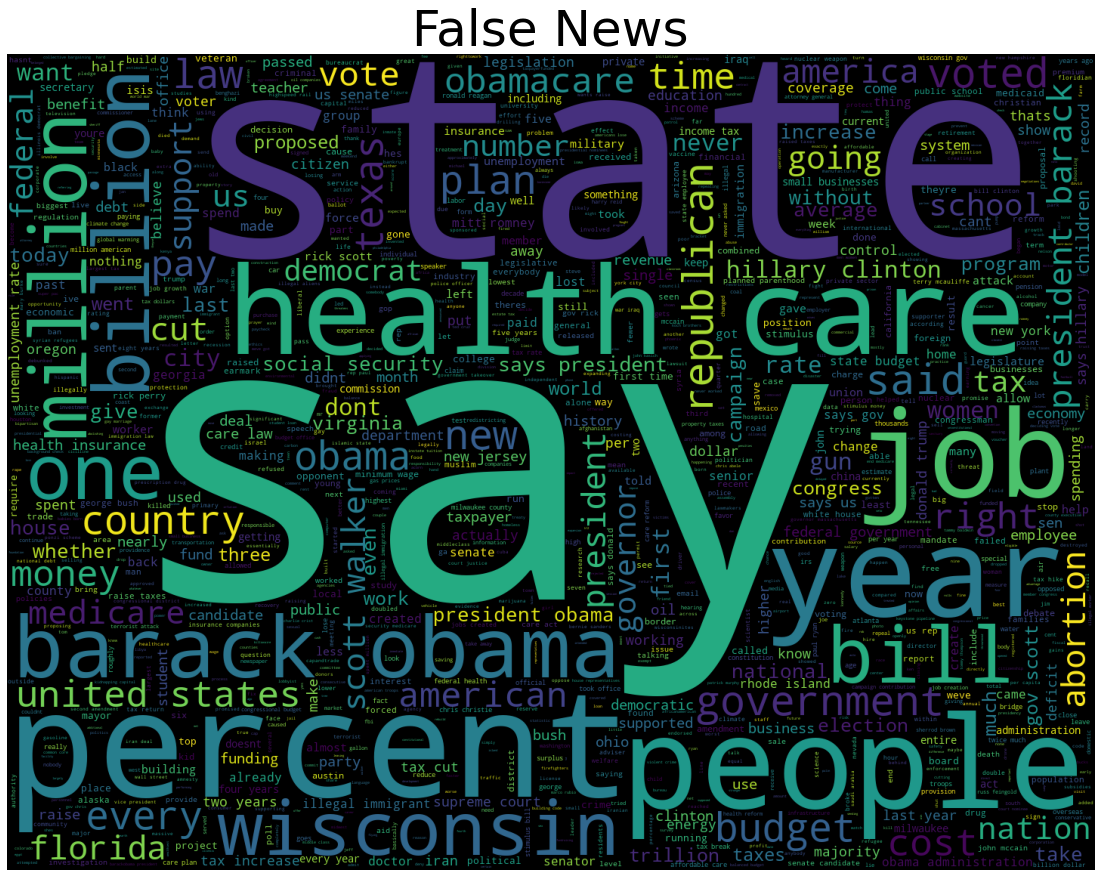

In [8]:
cloud = WordCloud(width=1440, height= 1080,max_words= 1200).generate(' '.join(df[df['Labels']==1]['clean_text'].astype(str)))
plt.figure(figsize=(20, 15))
plt.title('False News', fontsize = 50)
plt.imshow(cloud)
plt.axis('off')

## Data Preparation

In [20]:
num_classes = (df['Labels'].nunique())

In [21]:
X = df['clean_text']
y = tf.keras.utils.to_categorical(df['Labels'], num_classes)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index

In [24]:
vocab_length = len(train_word_index) + 1
vocab_length

11946

In [25]:
train_sequences = train_tokenizer.texts_to_sequences(X_train)
len(train_sequences)

8192

In [26]:
test_sequences = train_tokenizer.texts_to_sequences(X_test)
len(test_sequences)

2048

In [27]:
maxlen=20
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen, truncating='post')
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen, truncating='post')

## Model-RNN

In [28]:
embedding_dim = 6
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=maxlen),
    tf.keras.layers.SimpleRNN(64, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(32, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(16, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 6)             71676     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 20, 64)            4544      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20, 32)            3104      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 16)                784       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1

In [29]:
history = model.fit(train_padded_seqeunces, y_train, epochs=20, validation_data=(test_padded_seqeunces, y_test))

2022-10-16 11:12:00.230223: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
256/256 [==============================] - 10s 25ms/step - loss: 1.7820 - f1_score: 0.1533 - val_loss: 1.7642 - val_f1_score: 0.1104
Epoch 2/20
256/256 [==============================] - 6s 23ms/step - loss: 1.7391 - f1_score: 0.1917 - val_loss: 1.7719 - val_f1_score: 0.1178
Epoch 3/20
256/256 [==============================] - 7s 27ms/step - loss: 1.6221 - f1_score: 0.2876 - val_loss: 1.8619 - val_f1_score: 0.1377
Epoch 4/20
256/256 [==============================] - 6s 24ms/step - loss: 1.4074 - f1_score: 0.4007 - val_loss: 2.0474 - val_f1_score: 0.1497
Epoch 5/20
256/256 [==============================] - 6s 23ms/step - loss: 1.1471 - f1_score: 0.5380 - val_loss: 2.2761 - val_f1_score: 0.1658
Epoch 6/20
256/256 [==============================] - 6s 23ms/step - loss: 0.8846 - f1_score: 0.6749 - val_loss: 2.6144 - val_f1_score: 0.1713
Epoch 7/20
256/256 [==============================] - 6s 22ms/step - loss: 0.6924 - f1_score: 0.7533 - val_loss: 2.9883 - val_f1_score: 0.165

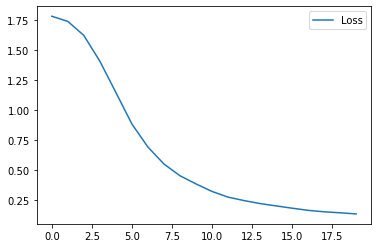

In [30]:
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [31]:
model.evaluate(test_padded_seqeunces, y_test)

64/64 [==============================] - 1s 11ms/step - loss: 5.1777 - f1_score: 0.1749


[5.177659034729004,
 array([0.16848674, 0.21346886, 0.20048901, 0.19083023, 0.09742121,
        0.17867434], dtype=float32)]

In [32]:
test_prob = model.predict(test_padded_seqeunces)
test_pred = np.where(test_prob > 0.5, 1, 0)

## Model Evaluation

In [35]:
print("Log-Loss: ", log_loss(y_test, test_prob))
print("F1-Score: ", f1_score(y_test, test_pred, average = 'weighted'))

Log-Loss:  5.177658626982968
F1-Score:  0.1803176467838586


**Variable Description:**

**Text** - Raw content from social media/ new platforms

**Text_Tag** - Different types of content tags

**Labels** - Represents various classes of Labels

● Barely-True - 0

● False - 1

● Half-True - 2

● Mostly-True - 3

● Not-Known - 4

● True - 5

In [36]:
labels = ['Barely-True', 'False', 'Half-True', 'Mostly-True', 'Not-Known', 'True']
conf_mat = multilabel_confusion_matrix(y_test, test_pred)

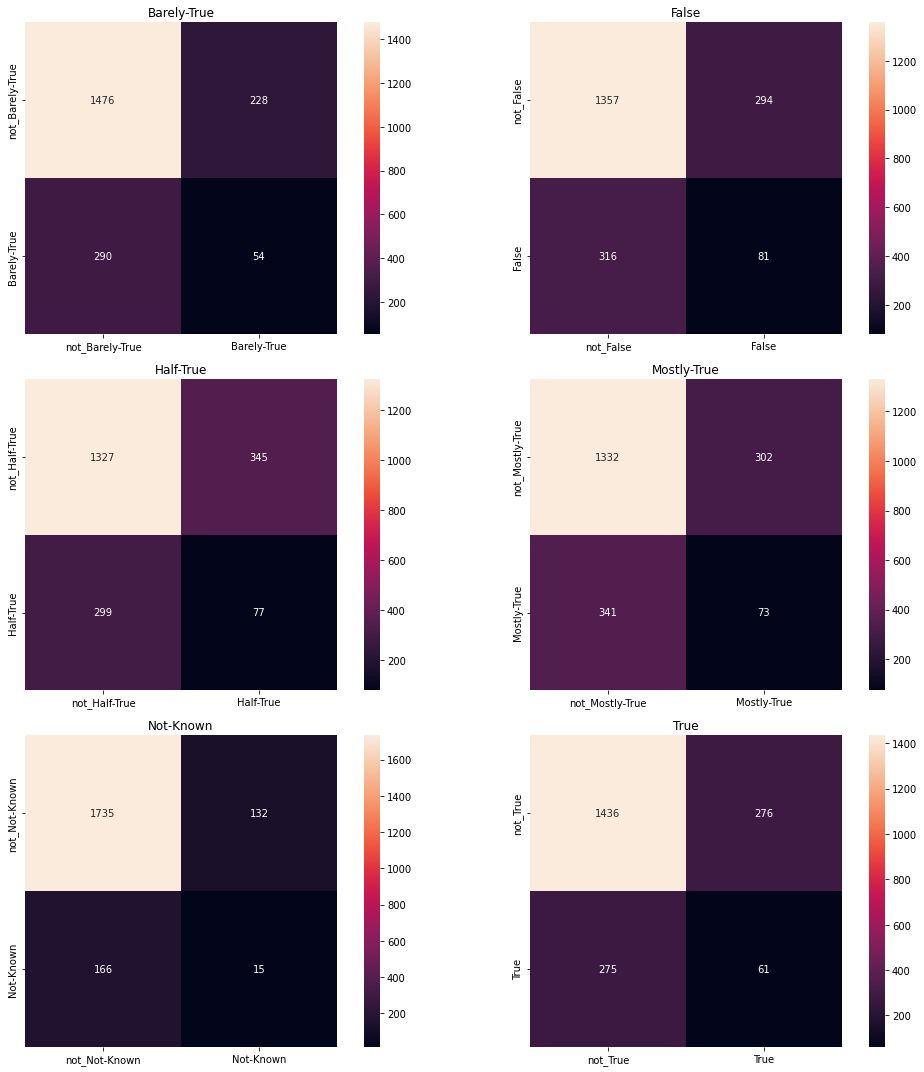

In [39]:
fig = plt.figure(figsize = (15, 15))
for i, (label, matrix) in enumerate(zip(labels, conf_mat)):
    plt.subplot(3, 2, i+1)
    l = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, square = True, xticklabels = l, yticklabels = l, fmt='d')
    plt.title(label)
plt.tight_layout()
plt.show()